In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 0️⃣ Install / upgrade required packages
# (Run this cell first in Colab Pro)
!pip install -q --upgrade transformers accelerate bitsandbytes torch

# ─────────────────────────────────────────────────────────────────────────────


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00


In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# 1️⃣ Imports & device
import os, re, time
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# If you need to authenticate for private or gated models:
token = os.getenv("HF_TOKEN")  # ✅ much safer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# ────────────────────────────────────────────────────────────────────────────
# 2️⃣ Load & slice one year of data (8 640 hourly temps)
df = (
    pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
      .sort_values("Formatted Date")
      .reset_index(drop=True)
)
FEATURE = "Temperature (C)"
LOOKBACK = 8640   # 1 year of hourly samples
HORIZON  = 720    # 30 days × 24 h

temps = df[FEATURE].values[-LOOKBACK:]
assert temps.shape[0] == LOOKBACK
# ────────────────────────────────────────────────────────────────────────────
# 3️⃣ Build the direct multi‑step prompt
# WARNING: this is very long—ensure your context size can hold ~8640 tokens + space for 720 outputs.
temps_list = [round(float(x),1) for x in temps]
# join without spaces to save tokens; you can also downsample if you hit truncation
input_str = ",".join(str(x) for x in temps_list)

prompt = (
    f"Given the past {LOOKBACK} hourly temperatures: [{input_str}], "
    f"predict the next {HORIZON} hourly temperatures. "
    "Reply with a comma‑separated list of numbers."
)
# ────────────────────────────────────────────────────────────────────────────
# 4️⃣ Load Mistral‑7B FP16 via Accelerate
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
token = os.environ["HUGGINGFACE_HUB_TOKEN"]

tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=os.environ["HUGGINGFACE_HUB_TOKEN"],
    torch_dtype=torch.float16,
    device_map="cuda"   # ⚠️ this loads everything into GPU
)


model.eval()
# ────────────────────────────────────────────────────────────────────────────
# 5️⃣ Tokenize, generate, and time it
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    truncation=True,
    max_length=8192  # adjust if you have a longer context window
).to(device)

start = time.time()
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4096,   # allow space for up to ~4k tokens of answers
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
elapsed = time.time() - start
print(f"Single-shot generation took {elapsed:.1f} seconds")
# ────────────────────────────────────────────────────────────────────────────
# 6️⃣ Decode & parse out 720 floats
resp = tokenizer.decode(outputs[0], skip_special_tokens=True)
nums = re.findall(r"[-+]?\d*\.\d+|\d+", resp)
preds = [float(x) for x in nums[:HORIZON]]

print(f"Parsed {len(preds)} hourly predictions:")
print(preds)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Single-shot generation took 205.4 seconds
Parsed 720 hourly predictions:
[8640.0, -0.0, 0.0, 0.0, 0.0, 0.1, -0.0, -0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.0, 0.0, -0.1, -2.1, -2.9, -4.0, -3.4, -6.7, -4.7, -4.5, -5.6, -5.1, -4.5, -4.0, -3.0, -3.0, -2.9, -2.9, -2.8, -2.8, -2.8, -2.0, -1.2, -1.1, -1.1, -1.1, -0.1, -0.1, -0.1, -0.5, -0.4, -0.5, -0.0, 0.1, 0.0, 0.5, 0.6, 1.1, 1.0, 1.0, 1.1, 1.1, 2.1, 2.1, 2.1, 2.4, 2.2, 2.2, 2.5, 2.1, 2.1, 2.8, 2.6, 2.6, 2.0, 3.2, 3.2, 2.5, 2.6, 3.7, 3.8, 3.7, 4.7, 4.9, 5.8, 5.9, 6.0, 6.9, 6.9, 7.3, 5.9, 4.9, 4.1, 2.2, 1.1, 0.4, 0.0, 0.0, 0.3, 0.5, 2.7, 3.4, 4.2, 4.2, 4.4, 3.6, 4.6, 4.7, 6.8, 8.4, 10.1, 10.7, 12.4, 12.5, 13.7, 12.6, 12.1, 12.1, 12.1, 11.0, 11.0, 12.0, 11.0, 10.7, 8.7, 7.3, 6.5, 6.6, 6.0, 6.0, 5.0, 4.9, 5.9, 6.0, 7.4, 7.1, 7.9, 9.9, 11.1, 10.0, 7.7, 6.1, 6.0, 5.0, 5.2, 5.1, 5.4, 3.3, 2.2, 1.7, 1.7, 0.7, 0.2, 0.0, 0.0, 1.1, 1.2, 2.8, 5.1, 7.6, 7.6, 7.7, 7.6, 7.2, 5.1, 3.9, 3.9, 3.8, 3.9, 4.4, 3.8, 2.7, 3.3, 3.1, 2.8, 3.7, 2.5, 2.1

In [ ]:
preds

[8640.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 -0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.1,
 0.1,
 0.1,
 0.0,
 0.0,
 -0.1,
 -2.1,
 -2.9,
 -4.0,
 -3.4,
 -6.7,
 -4.7,
 -4.5,
 -5.6,
 -5.1,
 -4.5,
 -4.0,
 -3.0,
 -3.0,
 -2.9,
 -2.9,
 -2.8,
 -2.8,
 -2.8,
 -2.0,
 -1.2,
 -1.1,
 -1.1,
 -1.1,
 -0.1,
 -0.1,
 -0.1,
 -0.5,
 -0.4,
 -0.5,
 -0.0,
 0.1,
 0.0,
 0.5,
 0.6,
 1.1,
 1.0,
 1.0,
 1.1,
 1.1,
 2.1,
 2.1,
 2.1,
 2.4,
 2.2,
 2.2,
 2.5,
 2.1,
 2.1,
 2.8,
 2.6,
 2.6,
 2.0,
 3.2,
 3.2,
 2.5,
 2.6,
 3.7,
 3.8,
 3.7,
 4.7,
 4.9,
 5.8,
 5.9,
 6.0,
 6.9,
 6.9,
 7.3,
 5.9,
 4.9,
 4.1,
 2.2,
 1.1,
 0.4,
 0.0,
 0.0,
 0.3,
 0.5,
 2.7,
 3.4,
 4.2,
 4.2,
 4.4,
 3.6,
 4.6,
 4.7,
 6.8,
 8.4,
 10.1,
 10.7,
 12.4,
 12.5,
 13.7,
 12.6,
 12.1,
 12.1,
 12.1,
 11.0,
 11.0,
 12.0,
 11.0,
 10.7,
 8.7,
 7.3,
 6.5,
 6.6,
 6.0,
 6.0,
 5.0,
 4.9,
 5.9,
 6.0,
 7.4,
 7.1,
 7.9,
 9.9,
 11.1,
 10.0,
 7.7,
 6.1,
 6.0,
 5.0,
 5.2,
 5.1,
 5.4,
 3.3,
 2.2,
 1.7,
 1.7,
 0.7,
 0.2,
 0.0,
 0.0,
 1.1,
 1.2,
 2.8,
 5.1,
 7.6,
 7.6,

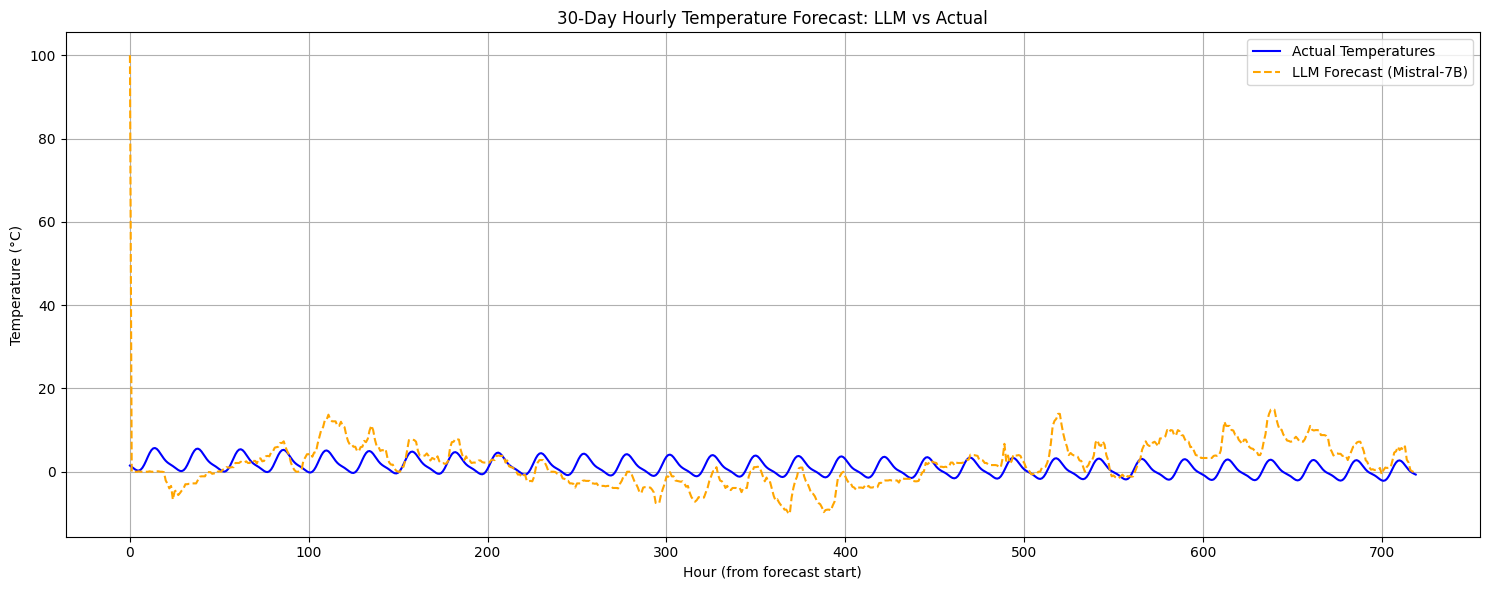

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays
actual = np.array(next_month_actual)
preds = np.array(llm_preds)

# Remove extreme outliers from preds (e.g., values > 100 or < -50)
preds_cleaned = np.clip(preds, -50, 100)

# Time index
hours = np.arange(len(actual))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(hours, actual, label="Actual Temperatures", color='blue')
plt.plot(hours, preds_cleaned, label="LLM Forecast (Mistral-7B)", color='orange', linestyle='--')
plt.xlabel("Hour (from forecast start)")
plt.ylabel("Temperature (°C)")
plt.title("30-Day Hourly Temperature Forecast: LLM vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


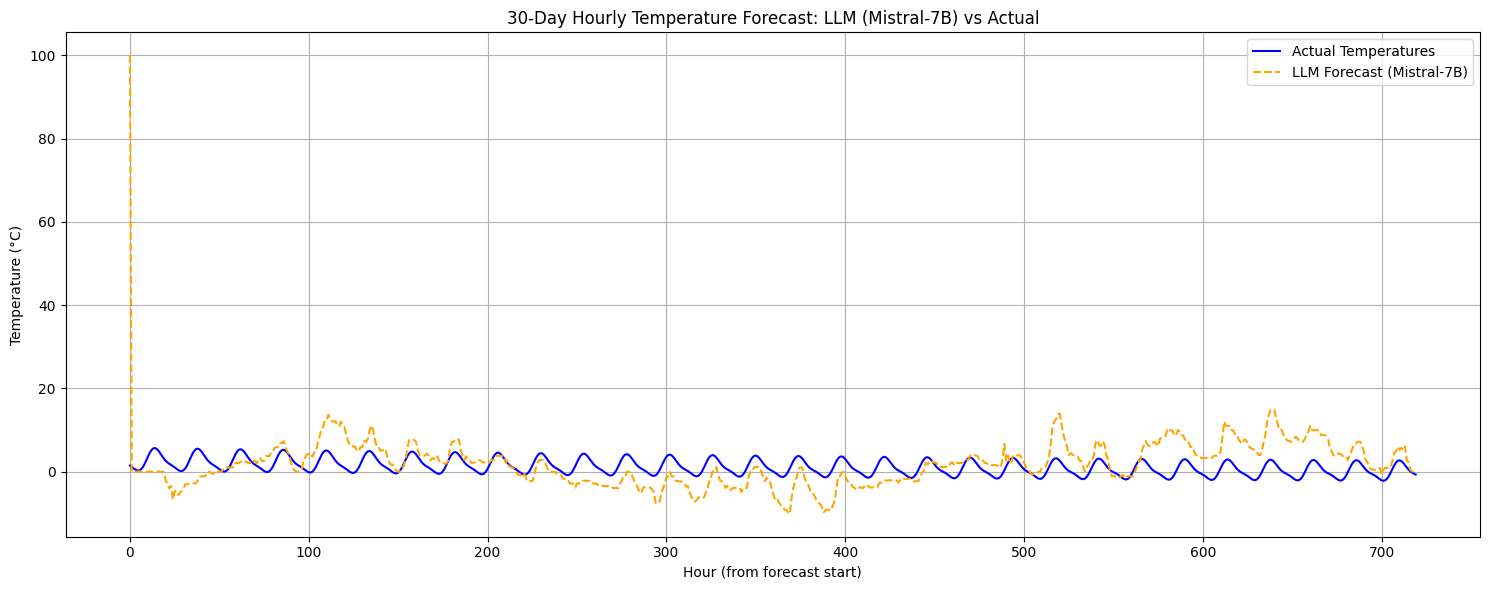

In [ ]:
# Ensure predictions are safe for plotting
llm_preds = np.array(llm_preds)
llm_preds_clipped = np.clip(llm_preds, -50, 100)

plt.figure(figsize=(15, 6))
plt.plot(hours, next_month_actual, label="Actual Temperatures", color='blue')
plt.plot(hours, llm_preds_clipped, label="LLM Forecast (Mistral-7B)", color='orange', linestyle='--')
plt.xlabel("Hour (from forecast start)")
plt.ylabel("Temperature (°C)")
plt.title("30-Day Hourly Temperature Forecast: LLM (Mistral-7B) vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install prophet -q


In [ ]:
from prophet import Prophet
import pandas as pd

# Load and sort the dataset
df = pd.read_csv("weatherHistory.csv", parse_dates=["Formatted Date"])
df = df.sort_values("Formatted Date").reset_index(drop=True)

# Step 1: Ensure datetime is parsed correctly and convert to UTC first
df["Formatted Date"] = pd.to_datetime(df["Formatted Date"], utc=True)

# Step 2: Then remove timezone (convert to naive datetime)
df["Formatted Date"] = df["Formatted Date"].dt.tz_localize(None)

# Step 3: Prepare dataframe for Prophet
df_prophet = df[["Formatted Date", "Temperature (C)"]].rename(
    columns={"Formatted Date": "ds", "Temperature (C)": "y"}
)

# Split data into train and test (last 720 hours as test set)
train_df = df_prophet[:-720]
test_df = df_prophet[-720:]

# Step 4: Fit Prophet model
model = Prophet()
model.fit(train_df)

# Step 5: Forecast next 720 hours
future = model.make_future_dataframe(periods=720, freq='H')
forecast = model.predict(future)

# Step 6: Extract predictions
prophet_preds = forecast[-720:]["yhat"].values
next_month_actual = test_df["y"].values

print("✅ Forecast complete. Prophet predicted", len(prophet_preds), "values.")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpigryjfa2/6l_pedpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpigryjfa2/oi5jbhuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23537', 'data', 'file=/tmp/tmpigryjfa2/6l_pedpf.json', 'init=/tmp/tmpigryjfa2/oi5jbhuj.json', 'output', 'file=/tmp/tmpigryjfa2/prophet_modela9j_sk6t/prophet_model-20250420170942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


✅ Forecast complete. Prophet predicted 720 values.


<ipython-input-23-65dd6b81e6d8>:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


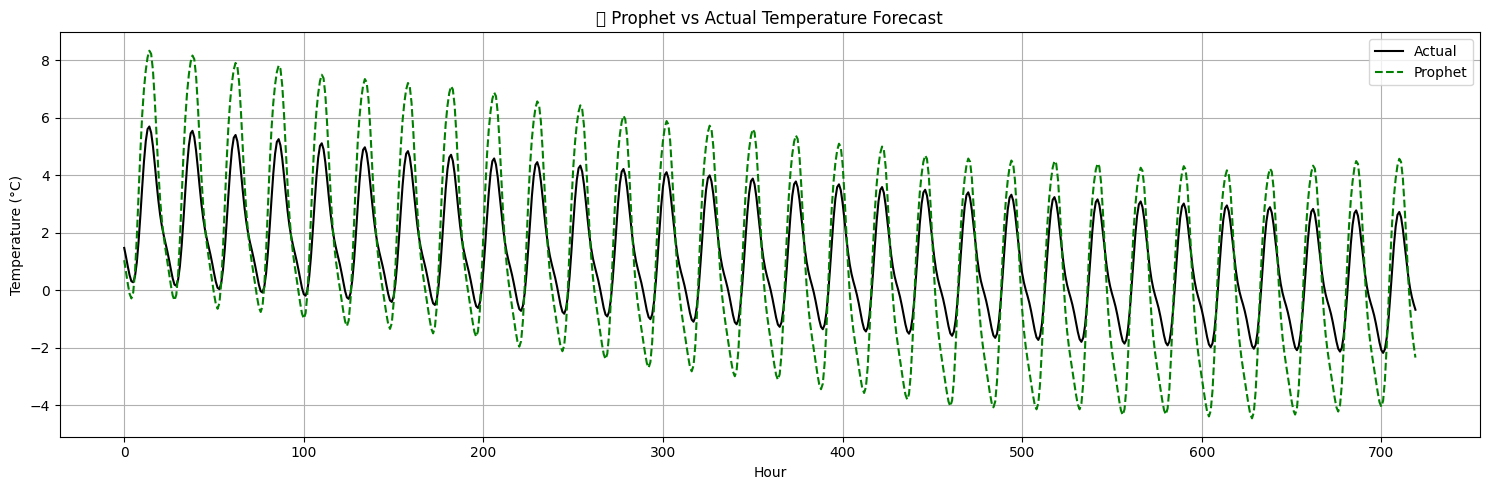

<ipython-input-23-65dd6b81e6d8>:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


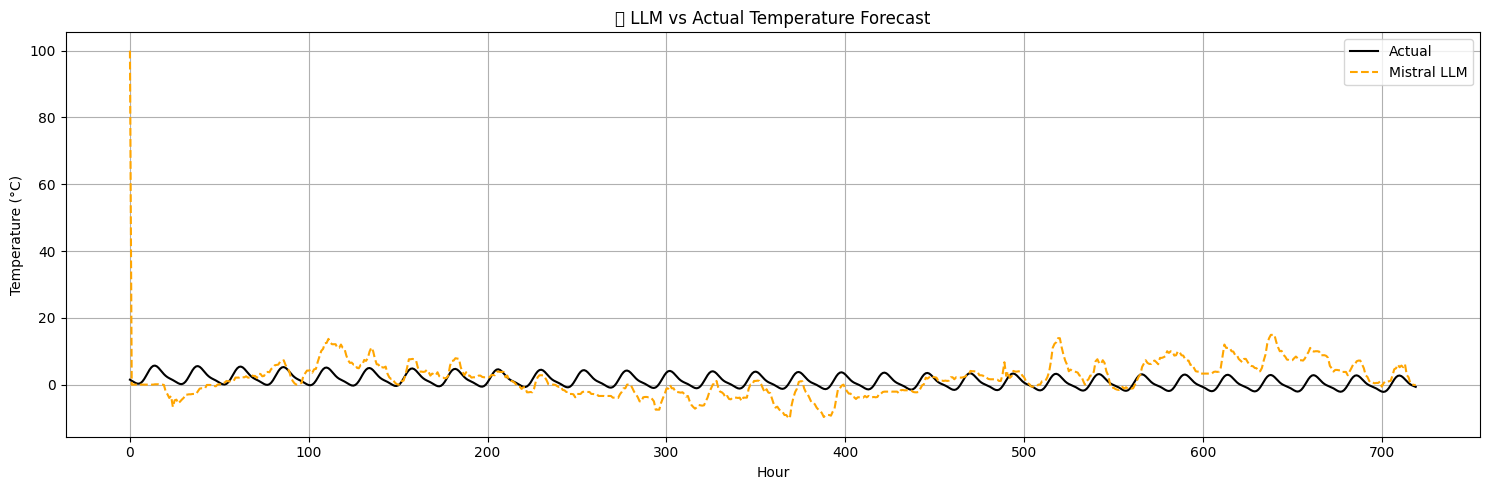

<ipython-input-23-65dd6b81e6d8>:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


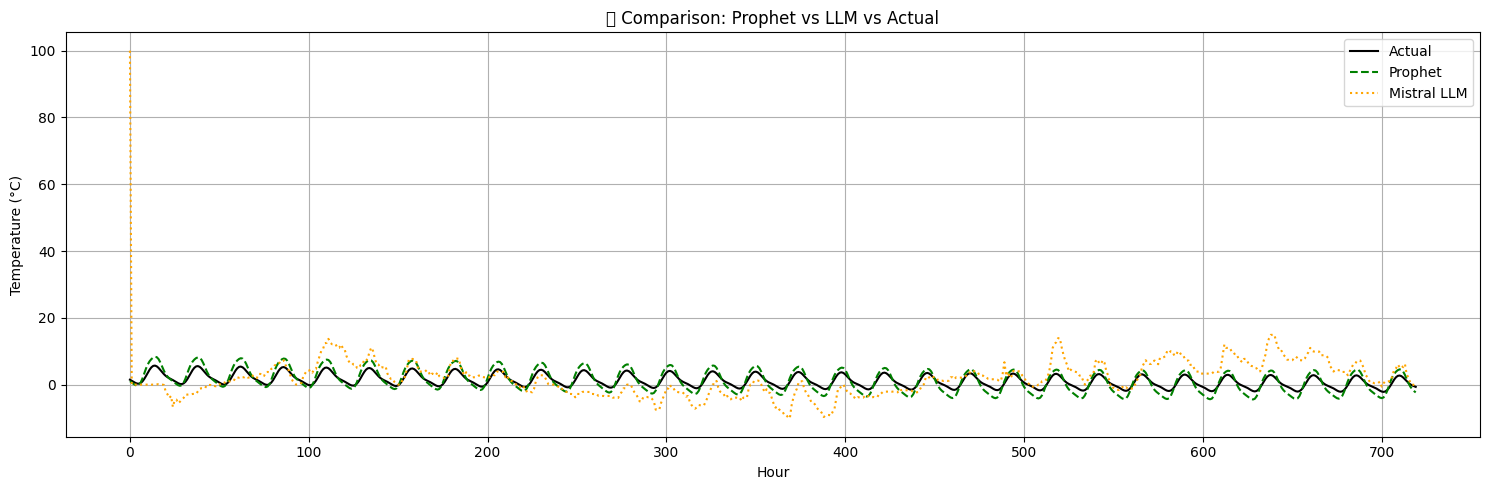


🔎 Prophet Metrics:
  RMSE : 1.5413
  MAE  : 1.3587
  R²   : 0.3189

🔎 Mistral LLM Metrics:
  RMSE : 6.0220
  MAE  : 4.0817
  R²   : -9.3983


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Create time axis
time = np.arange(720)

# Clean LLM predictions (replace with your actual LLM output variable if needed)
llm_preds_array = np.array(llm_preds)
llm_preds_cleaned = np.clip(llm_preds_array, -50, 100)  # clip outliers for safe plot

# ========== 📊 PLOT 1: Prophet vs Actual ==========
plt.figure(figsize=(15, 5))
plt.plot(time, next_month_actual, label="Actual", color="black")
plt.plot(time, prophet_preds, label="Prophet", color="green", linestyle="--")
plt.title("📈 Prophet vs Actual Temperature Forecast")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 📊 PLOT 2: LLM vs Actual ==========
plt.figure(figsize=(15, 5))
plt.plot(time, next_month_actual, label="Actual", color="black")
plt.plot(time, llm_preds_cleaned, label="Mistral LLM", color="orange", linestyle="--")
plt.title("📈 LLM vs Actual Temperature Forecast")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 📊 PLOT 3: Prophet vs LLM vs Actual ==========
plt.figure(figsize=(15, 5))
plt.plot(time, next_month_actual, label="Actual", color="black")
plt.plot(time, prophet_preds, label="Prophet", color="green", linestyle="--")
plt.plot(time, llm_preds_cleaned, label="Mistral LLM", color="orange", linestyle=":")
plt.title("📈 Comparison: Prophet vs LLM vs Actual")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== 📐 METRICS ==========
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Manual RMSE
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n🔎 {name} Metrics:")
    print(f"  RMSE : {rmse:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  R²   : {r2:.4f}")

print_metrics("Prophet", next_month_actual, prophet_preds)
print_metrics("Mistral LLM", next_month_actual, llm_preds_cleaned)



In [ ]:
import pandas as pd

# Create DataFrame with hourly index
hours = list(range(720))

# Save predictions and actual values
results_df = pd.DataFrame({
    "Hour": hours,
    "Actual_Temp": next_month_actual,
    "Prophet_Pred": prophet_preds,
    "LLM_Pred": llm_preds_cleaned
})

# Save to CSV
results_df.to_csv("temperature_forecast_comparison.csv", index=False)
print("✅ Saved to temperature_forecast_comparison.csv")


✅ Saved to temperature_forecast_comparison.csv
